# Deep StepMania

In [1]:
import os
import numpy as np
import re
from importlib import reload
import pandas as pd
import matplotlib.pyplot as plt
from deepSM import SMDataset
from deepSM import StepPlacement

import torch
from torch import nn
from torch import optim
import torch.utils.data as datautils
%matplotlib inline

## Data parsing.

In [2]:
song_names = os.listdir('data')

In [43]:
reload(SMDataset)
# dataset = SMDataset.SMDataset(song_names[10])
dataset = SMDataset.get_dataset(song_names)

In [44]:
len(dataset)

897448

In [45]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train_ds, test_ds = datautils.random_split(dataset, [train_size, test_size])

In [46]:
reload(SMDataset)

# sampler = SMDataset.WeightedRandomSampler(train_ds)

train_loader = datautils.DataLoader(
    train_ds, num_workers=4, 
    batch_size= 64,
    shuffle=True)
#     sampler=sampler)

In [47]:
reload(StepPlacement)

device = torch.device('cuda:0')

conv_model = StepPlacement.ConvStepPlacementModel()
conv_model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(conv_model.parameters())

for epoch in range(10):
    print("Starting epoch", epoch+1)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        labels = data['labels'].cuda()
        fft_features = data['fft_features'].cuda()
        
        optimizer.zero_grad()

        outputs = conv_model(fft_features)
        loss = criterion(outputs, labels)
        accuracy = torch.mean(torch.abs(labels - outputs))

        loss.backward()
        optimizer.step()
        
#         print(loss.item())

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 500))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

print("Training complete.")

Starting epoch 1


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   500] loss: 113.580
[1,  1000] loss: 110.234
[1,  1500] loss: 105.936
[1,  2000] loss: 107.217
[1,  2500] loss: 110.330
[1,  3000] loss: 107.007
[1,  3500] loss: 103.371
[1,  4000] loss: 108.985
[1,  4500] loss: 104.927
[1,  5000] loss: 106.260
[1,  5500] loss: 104.628
[1,  6000] loss: 110.151
[1,  6500] loss: 103.773
[1,  7000] loss: 104.885
[1,  7500] loss: 106.279
[1,  8000] loss: 102.446
[1,  8500] loss: 104.504
[1,  9000] loss: 101.795
[1,  9500] loss: 104.963
[1, 10000] loss: 104.317
[1, 10500] loss: 104.199
Starting epoch 2
[2,   500] loss: 104.080
[2,  1000] loss: 105.344
[2,  1500] loss: 105.517
[2,  2000] loss: 101.107
[2,  2500] loss: 102.722
[2,  3000] loss: 101.244
[2,  3500] loss: 102.519
[2,  4000] loss: 102.873
[2,  4500] loss: 102.590
[2,  5000] loss: 98.182
[2,  5500] loss: 99.362
[2,  6000] loss: 101.354
[2,  6500] loss: 97.968
[2,  7000] loss: 100.563
[2,  7500] loss: 99.420
[2,  8000] loss: 99.674
[2,  8500] loss: 98.871
[2,  9000] loss: 99.360
[2,  9500] loss

In [48]:
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve

In [49]:
reload(SMDataset)
# sampler = SMDataset.WeightedRandomSampler(test_ds)
test_loader = datautils.DataLoader(
    test_ds, num_workers=4, 
    batch_size=20000)

In [50]:
with torch.no_grad():
    accs = []
    for d in test_loader:
        labels = d['labels'].cuda()
        fft_features = d['fft_features'].cuda()
        
        outputs = conv_model(fft_features)
#         preds = torch.round(outputs)
        preds = (outputs > 0.06).float()
        
        accuracy = torch.mean(torch.abs(labels - preds))
        print("XXXXXXXXXXX")
        print(torch.stack([labels.reshape(-1), preds.reshape(-1)]))
        print(torch.abs(labels.reshape(-1) - preds.reshape(-1)))
        print(torch.mean(preds))
        accs.append(accuracy)
        
    print("Accuracy:", 1 - np.mean(list(map(lambda acc: acc.cpu().numpy(), accs))))
    
    roc = roc_auc_score(
        labels.cpu().numpy().reshape(-1), 
        outputs.cpu().numpy().reshape(-1))
    
    print("ROC:", roc)
    
    precision, recall, thresh = precision_recall_curve(
        labels.cpu().numpy().reshape(-1), 
        outputs.cpu().numpy().reshape(-1))
    
    prauc = auc(recall, precision)
    print("AUC PR:", prauc)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


XXXXXXXXXXX
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor(0.2700, device='cuda:0')
XXXXXXXXXXX
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor(0.2630, device='cuda:0')
XXXXXXXXXXX
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor(0.2659, device='cuda:0')
XXXXXXXXXXX
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 0.]], device='cuda:0')
tensor([1., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
tensor(0.2620, device='cuda:0')
XXXXXXXXXXX
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.]], device='cuda:0')
tensor([0., 0., 1.,  ..., 0., 1., 0.], device='cuda:0')
tensor(0.2675, device='cuda:0')
XXXXXXXXXX

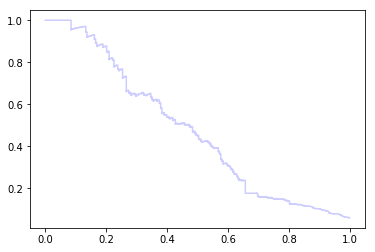

In [51]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')